In [59]:
import pandas as pd
import json
import os
import re
import random
from scipy import sparse
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
from stop_words import get_stop_words
import gensim
from nltk.stem import WordNetLemmatizer

import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

# Preprocessing Data


In [2]:
dirPath = 'spotify_million_playlist_dataset/data/'

files = os.listdir(dirPath)
sorted(files)

# Chnage this number if needed 
number_of_json_file = 1
playlist_frames = []

for i in range(number_of_json_file):
    data = json.load(open(dirPath+files[i]))
    df = pd.DataFrame(data['playlists'])
    playlist_frames.append(df)

data = pd.concat(playlist_frames)
data.head(2)

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,tracks,num_edits,duration_ms,num_artists,description
0,Bob Dylan,false,549000,1454803200,75,65,1,"[{'pos': 0, 'artist_name': 'Bob Dylan', 'track...",28,18425368,39,NaN
1,ON THE RUN,false,549001,1419552000,61,30,1,"[{'pos': 0, 'artist_name': 'JAY Z', 'track_uri...",4,15224873,5,NaN


In [3]:
data.shape

(1000, 12)

In [4]:
data.drop(['collaborative','modified_at','num_edits','description'], axis=1, inplace=True)

In [5]:
data.head()

,name,pid,num_tracks,num_albums,num_followers,tracks,duration_ms,num_artists
0,Bob Dylan,549000,75,65,1,"[{'pos': 0, 'artist_name': 'Bob Dylan', 'track...",18425368,39
1,ON THE RUN,549001,61,30,1,"[{'pos': 0, 'artist_name': 'JAY Z', 'track_uri...",15224873,5
2,Biking,549002,144,117,1,"[{'pos': 0, 'artist_name': 'Sander van Doorn',...",32723071,72
3,August,549003,38,32,1,"[{'pos': 0, 'artist_name': 'C-Trox', 'track_ur...",8439352,33
4,run mix,549004,16,15,1,"[{'pos': 0, 'artist_name': 'Buzzcocks', 'track...",3804816,12


In [6]:
tracks_frame = []

for index, row in data.iterrows():
    t = pd.DataFrame(row['tracks'])
    t['num_followers'] = row['num_followers']
    t.drop(['pos','artist_uri','album_uri','duration_ms'], axis=1, inplace=True)
    tracks_frame.append(t)
    
tracks_data = pd.concat(tracks_frame)   

In [7]:
follower_count = pd.DataFrame(tracks_data.groupby('track_uri')['num_followers'].sum())
tracks_data.drop('num_followers',axis=1,inplace=True)
tracks_data.drop_duplicates(inplace=True)
tracks_data.set_index('track_uri', inplace=True)
tracks_data = pd.concat([tracks_data,follower_count],axis=1)

In [8]:
tracks_data.shape

(35790, 4)

## Combine track_name and album_name

In [9]:
tracks_data['documents'] = tracks_data['track_name'].apply(lambda s: s.lower()) + ' ' + tracks_data['album_name'].apply(lambda s: s.lower())

In [10]:
def lemmatization(words):
    lemmatizer = WordNetLemmatizer()
    result = []
    for word in words.split(' '):
        result.append(lemmatizer.lemmatize(word))
    return ' '.join(result)

def remove_stopword(words):
    result = []
    sw = list(STOPWORDS) + stopwords.words('english') + get_stop_words('english') + list(gensim.parsing.preprocessing.STOPWORDS)
    for word in words.split(' '):
        if word not in sw:
            result.append(word)
    return ' '.join(result)

def remove_single_and_two_characters(words):
    result = []
    for word in words.split(' '):
        if len(word) > 2:
            result.append(word)
    return ' '.join(result)  

def remove_any_numbers_besides_year(words):
    result = []
    for word in words.split(' '):
        if not word.isnumeric() or len(word) == 4:
            result.append(word)
    return ' '.join(result)

In [11]:
tracks_data['documents'] = tracks_data['documents'].apply(lemmatization)
tracks_data['documents'] = tracks_data['documents'].apply(remove_stopword)
tracks_data['documents'] = tracks_data['documents'].apply(lambda s: re.sub(r'[^a-z0-9]',' ',s))
tracks_data['documents'] = tracks_data['documents'].apply(remove_single_and_two_characters)
tracks_data['documents'] = tracks_data['documents'].apply(remove_any_numbers_besides_year)

### Drop the rows with empty string after preprocessing words

In [12]:
d = tracks_data['documents'].apply(len).to_dict()
t = dict(filter(lambda x: x[1]==0,d.items()))

tracks_data = tracks_data.drop(list(t.keys()))
tracks_data.shape

(35264, 5)

### Save preprocessed dataset to csv

In [13]:
tracks_data.head()

,artist_name,track_name,album_name,num_followers,documents
track_uri,,,,,
spotify:track:6QHYEZlm9wyfXfEM1vSu1P,Bob Dylan,Boots of Spanish Leather,The Times They Are A-Changin',2,boot spanish leather time changin
spotify:track:3RkQ3UwOyPqpIiIvGVewuU,Bob Dylan,Mr. Tambourine Man,Bringing It All Back Home,1,tambourine man bringing home
spotify:track:0ju1jP0cSPJ8tmojYBEI89,Loggins & Messina,Danny's Song,The Best: Loggins & Messina Sittin' In Again,5,danny song best loggins messina sittin
spotify:track:7ny2ATvjtKszCpLpfsGnVQ,Bob Dylan,A Hard Rain's A-Gonna Fall,The Freewheelin' Bob Dylan,1,hard rain gonna fall freewheelin bob dylan
spotify:track:18GiV1BaXzPVYpp9rmOg0E,Bob Dylan,Blowin' In the Wind,The Freewheelin' Bob Dylan,1,blowin wind freewheelin bob dylan


In [14]:
tracks_data.to_csv('data/preprocessed_dataset.csv')

# Feature Engineering 

In [65]:
tracks_data = pd.read_csv('data/preprocessed_dataset.csv')
tracks_data.set_index('track_uri', inplace=True)

In [66]:
def get_cos_matrix(X):
    cos_matrix = []
    for i in range(X.shape[0]):
        m = cosine_similarity(X[i],X[:])
        cos_matrix.append(m.flatten().tolist())
    return np.round(cos_matrix,4)

## Generate Features from track_name and album_name

In [87]:
all_words = " ".join(tracks_data['documents'].tolist())
freq_count = Counter(all_words.split(' '))
sorted(freq_count.items(),key=lambda x: x[1],reverse=True)[0:10]

[('feat', 2218),
 ('love', 2015),
 ('version', 1262),
 ('remix', 1213),
 ('live', 1066),
 ('original', 749),
 ('night', 729),
 ('time', 677),
 ('life', 652),
 ('remastered', 631)]

In [88]:
min_freq = int(np.percentile(list(freq_count.values()),95))

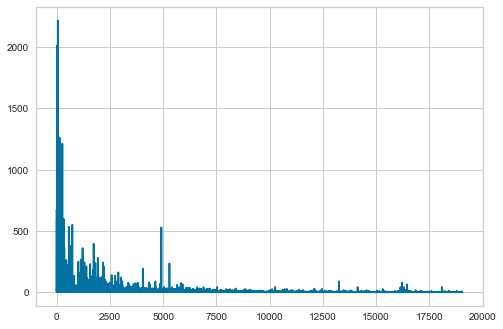

In [89]:
plt.plot(list(freq_count.values()))
plt.show()

In [90]:
vectorizer = TfidfVectorizer(min_df=min_freq)
X_documents = vectorizer.fit_transform(tracks_data['documents'])
X_documents = np.round(X_documents,4)

In [91]:
X_documents.shape

(35264, 897)

In [92]:
X = X_documents.todense()

In [95]:
SIM_matrix = get_cos_matrix(X)

# Estimate Number of Clusters for KMeans

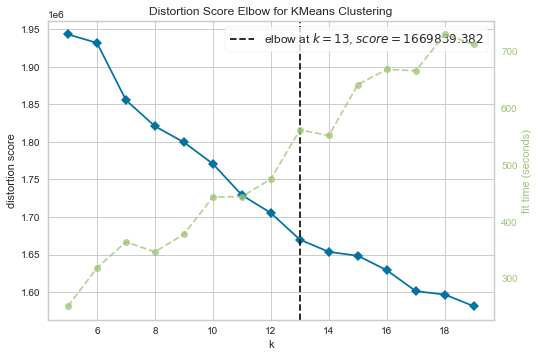

In [96]:
model = KMeans(init='k-means++',random_state=0)
visualizer = KElbowVisualizer(model, k=(5,20))
visualizer.fit(SIM_matrix)
visualizer.poof()
k = visualizer.elbow_value_

# Build KMeans 

In [97]:
model = KMeans(n_clusters=k,init='k-means++',random_state=0).fit(SIM_matrix)

In [98]:
pickle.dump(model, open('kmeans_model_nlp.sav', 'wb'))